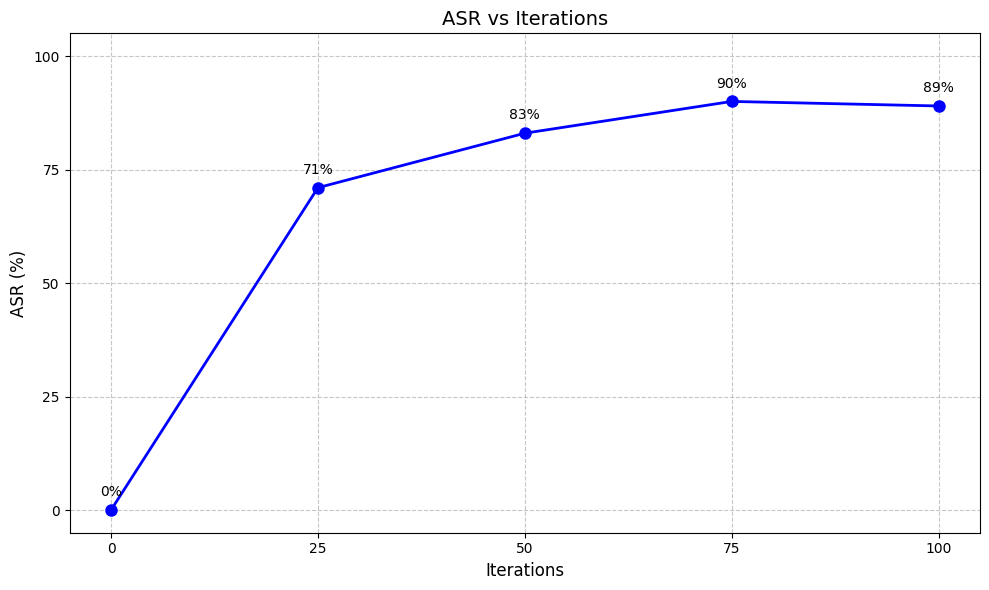

In [ ]:
import matplotlib.pyplot as plt


iterations = [0, 25, 50, 75, 100]
asr_values = [0, 71, 83, 90, 89] 


plt.figure(figsize=(10, 6))
plt.plot(iterations, asr_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)


# plt.title('ASR vs Iterations', fontsize=14)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('ASR (%)', fontsize=20)


plt.xlim(-5, 105)
plt.ylim(-5, 105)

plt.grid(True, linestyle='--', alpha=0.7)

for i, txt in enumerate(asr_values):
    plt.annotate(f"{txt}%", (iterations[i], asr_values[i]), 
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=10)

plt.xticks(iterations)
plt.yticks([0, 25, 50, 75, 100])


plt.tight_layout()
plt.show()

In [ ]:
import json
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import Counter


model_device = "cuda:1"

try:
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to("cuda:0")
except Exception as e:
    print(f"加载SentenceTransformer模型失败: {e}")
    print("请检查网络连接或手动下载模型: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2")
    raise Exception(f"加载SentenceTransformer模型失败: {e}")
def load_jsonl_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = json.loads(line.strip())
            if line["gptfuzz_result"] == "0":
                continue
            data.append(
                {
                    "orginal": line["orginal"],
                    "jailbreak_prompt": line["jailbreak_prompt"],
                    "response": line["response"][len(line["orginal"]):],
                    "gptfuzz_result": line["gptfuzz_result"],
                    "Guard3_unsafe": line["Guard3_unsafe"],
                }
            )
    return data




dataset = "advbench"
# dataset = "harmBench"


UJA_filename_format = "{dataset}_untarget_gptfuzz_100_evaluate.jsonl"
baseline_filename_format = "{dataset}_{method}_100_evaluate.jsonl"

baselines = [
    "gcg",
    "prp",
    "cold_suffix",
    "advPrefix",
    "drl",
    "pap2"
    
]

L = 20 # maximum length of the response

def get_embedding(response):
    response = response[:L]
    return model.encode(response, convert_to_tensor=True, device=model_device).cpu().numpy()

all_data = []
for baseline in baselines:
    baseline_data = load_jsonl_data(os.path.join("/data/home/Xinzhe/Untarget/data/evaluate/llama-3-8B-Instruct/", baseline_filename_format.format(dataset=dataset, method=baseline)))

    baseline_responses = [d["response"][:40] for d in baseline_data]
    baseline_response_embeddings = model.encode(baseline_responses, batch_size=32, show_progress_bar=True)
    baseline_response_embeddings = baseline_response_embeddings
    for baseline_data_item, baseline_response_embedding in zip(baseline_data, baseline_response_embeddings):
        baseline_data_item["response_embedding"] = baseline_response_embedding
        baseline_data_item["response"] = baseline_data_item["response"][:L]
        baseline_data_item["baseline"] = baseline
    all_data.extend(baseline_data)
    


UJA_data = load_jsonl_data(os.path.join("/data/home/Xinzhe/Kedong/repos/Untarget/output_score/gptfuzz/llama-3-8B-Instruct/", UJA_filename_format.format( dataset=dataset)))

DTA_responses = [d["response"][:40] for d in UJA_data]
DTA_response_embeddings = model.encode(DTA_responses, batch_size=32, show_progress_bar=True)
for DTA_data_item, DTA_response_embedding in zip(UJA_data, DTA_response_embeddings):
    DTA_data_item["response_embedding"] = DTA_response_embedding
    DTA_data_item["response"] = DTA_data_item["response"][:L]
    DTA_data_item["baseline"] = "UJA"
all_data.extend(UJA_data)

all_embeddings = np.array([d["response_embedding"] for d in all_data])

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(all_embeddings)
pca = PCA(n_components=50, random_state=42)
pca_out = pca.fit_transform(embeddings_scaled)
# embeddings_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(pca_out)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(pca_out)

all_baseline_labels = [d["baseline"] for d in all_data]
# all_success_flags = [d["gptfuzz_result"] for d in all_data]


all_success_flags = [
    "success" if d["gptfuzz_result"] == 1 else "failure"
    for d in all_data
]

success_counter = Counter()
for d in all_data:
    if d["gptfuzz_result"] == "1":
        success_counter[d["baseline"]] += 1
print(success_counter)


df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df["method"] = all_baseline_labels
df["success"] = all_success_flags
df["cluster"] = -1

for method in df["method"].unique():
    method_mask = df["method"] == method
    kmeans = KMeans(n_clusters=5, random_state=42)
    df.loc[method_mask, "cluster"] = kmeans.fit_predict(df.loc[method_mask, ["x", "y"]])


df.head()



import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

method_name_map = {
    "gcg": "GCG",
    "prp": "PRP",
    "cold_suffix": "COLD-Attack",
    "advPrefix": "AdvPrefix",
    "drl":"DRL",
    "pap2": "PAP",
    "UJA": "UJA"
}


plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=len(set(all_baseline_labels)))
# palette = sns.color_palette("tab10", n_colors=len(set(all_baseline_labels)))

method_color_map = dict(zip(sorted(set(all_baseline_labels)), palette))




for method in sorted(set(all_baseline_labels)):
    subset = df[(df["method"] == method) & (df["success"] == "success")]
    if len(subset) == 0:
        continue
    base_color = method_color_map[method]
    label = method_name_map.get(method, method)


    if method == "UJA":
        plt.scatter(subset["x"], subset["y"],
                    color=base_color,
                    edgecolor="black", 
                    linewidth=0.5,
                    s=80,  
                    marker="*",  
                    label=label,
                    alpha=1.0)
    else:
        plt.scatter(subset["x"], subset["y"],
                    color=base_color,
                    label=label,
                    s=30,
                    alpha=0.6)



for method in sorted(set(df["method"])):
    for cid in df[df["method"] == method]["cluster"].unique():
        group = df[(df["method"] == method) & (df["cluster"] == cid)]
        if len(group) < 2:
            continue
        cov = np.cov(group[["x", "y"]].T)
        mean = group[["x", "y"]].mean().values
        eigvals, eigvecs = np.linalg.eig(cov)
        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        width, height = 2 * np.sqrt(eigvals) * 2  
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

        ellipse = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            edgecolor=method_color_map[method],
            linestyle='--',
            linewidth=1.5,
            facecolor='none',
            alpha=0.6,
        )
        plt.gca().add_patch(ellipse)


# plt.title("Clustered Response Embeddings (Per-Method Clustering, Success Highlighted)")
plt.xticks([])
plt.yticks([])

plt.xlabel("X-axis (t-SNE 1)", fontsize=20)
plt.ylabel("Y-axis (t-SNE 2)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)  
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("response_embedding_cluster.pdf", dpi=300)
plt.show()







2025-06-25 10:21:08.339443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 10:21:09.816380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750818070.321413 3188099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750818070.441453 3188099 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 10:21:11.765550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

KeyboardInterrupt: 